### ROC
* 수신자 판단 곡선 (receiver operation characteristic)
* 세계 2차대전 통신장비 성능평가를 위해 고안된 수치
    + 레이더 데이터를 분석해서 적 항공기와 신호소음을 구분
    + 수신기의 감도가 증가함에 따라 거짓긍정(특이성)의 수가 감소
* 의학분야에 많이 사용되지만 머신러닝의 이진분류 모델 성능 평가에도 사용
* ROC 곡선의 y축은 민감도, x축은 1-재현율로 그림
* 모델이 양성/긍정으로 예측했을때 얼마나 잘 맞추고 있는지 설명

In [78]:
# 타이타닉 데이터셋을 로지스틱 회귀로 분석한 후 특이도/재현율을 구한 다음 ROC 그래프를 구하여라

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [80]:
titanic = pd.read_csv('titanic.csv')
titanic.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,embarked,life,seat,port
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,S,live,1st,southampthon
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,S,live,1st,southampthon
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,S,dead,1st,southampthon
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,S,dead,1st,southampthon
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,S,dead,1st,southampthon


In [81]:
titanic['gender'] = titanic['sex'].apply(lambda x : 0 if x == 'female' else 1)

In [82]:
titanic['harbor'] = titanic['embarked'].apply(lambda x:0 if x == 'C' else(1 if x == 'S' else 2))

In [83]:
# titanic.to_csv('titanic3.csv', index=False)

In [84]:
data = titanic.iloc[:, [0,4,5,6,8,13,14]]
target = titanic.survived

In [85]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [86]:
Xtrain, Xtest, ytrain, ytest = train_test_split(data, target, train_size=0.7, random_state=2111050955)

In [87]:
# max_iter=1000 <- warning 메시지 안띄우기 위해 옵션을 주었음 
lrclf = LogisticRegression(max_iter=1000)
lrclf.fit(Xtrain, ytrain)
pred = lrclf.predict(Xtest)

### 분류 알고리즘 종류
* 판별함수 모령
    + 주어진 데이터를 범주에 따라 서로 다른 영역으로 나누는 경계면을 찾아낸 후 이 경계면을 기준으로 데이터가 어디에 속하는지 계산하는 함수 사용
* 확률적 판별/생성 모형
    + 주어진 데이터에 대해 각 범주/레이블이 정답일 조건부확률을 계산하는 방법에 따라 조건부확률함수를 추정하거나 베이즈 정리를 사용해서 분류하는 모형
* 분류기의 예측 불확실성을 추정하려면 scikit-learn에서 제공하는 2가지함수 사용
    + predict / predict_proba

In [88]:
# 타이타닉 생존 예측확률 알아보기 1
Xtest[:5]
lrclf.predict(Xtest[:5]) # 예측결과는 이산형값으로 출력

array([0, 0, 0, 0, 0])

In [89]:
# 타이타닉 생존 예측확률 알아보기 2
lrclf.predict_proba(Xtest[:5]) # 예측결과는 확률수치로 출력

array([[0.75890403, 0.24109597],
       [0.53886971, 0.46113029],
       [0.90088691, 0.09911309],
       [0.90073139, 0.09926861],
       [0.95404784, 0.04595216]])

In [90]:
# 확률적 판별/생성 모형을 통해 특이도별 재현율의 변화를 살펴봄
lrclf.predict_proba(Xtest)[:5]

array([[0.75890403, 0.24109597],
       [0.53886971, 0.46113029],
       [0.90088691, 0.09911309],
       [0.90073139, 0.09926861],
       [0.95404784, 0.04595216]])

In [91]:
pred_proda = lrclf.predict_proba(Xtest)[:,1]
pred_proda.shape # 예측확률 건수

(392,)

In [94]:
# 실제값, 확률값, 예측값을 하나의 데이터프레임에 작성
df = pd.DataFrame()
df['ytest'] = ytest # 실제값
df['FP proba'] = pred_proda # FP 확률
df['pred'] = pred # 예측값
df.head()

,ytest,FP proba,pred
332,0,0.241096,0
164,1,0.461130,0
1289,0,0.099113,0
1279,0,0.099269,0
1001,1,0.045952,0


In [105]:
# 각 예측확률별 특이도(FPR)와 민감도(TPR), 임계값을 구함
# 즉, 생존했는데 사망했다고 예측한 비율과 
# 사망했는데 사망했다고 예측한 비율을 판단할때의 경계값을 살펴봄
from sklearn.metrics import roc_curve

In [106]:
fprs, tprs, thresholds = roc_curve(ytest, pred_proda)
print('음성판단',fprs[:10], fprs.shape)
print('양성판단',tprs[:10], tprs.shape)

음성판단 [0.         0.00396825 0.00396825 0.00396825 0.00396825 0.00793651
 0.00793651 0.01587302 0.01587302 0.01984127] (144,)
양성판단 [0.         0.         0.24285714 0.25714286 0.27857143 0.28571429
 0.33571429 0.33571429 0.35714286 0.35714286] (144,)


In [109]:
roc = pd.DataFrame({'FPR':fprs, 'TPR':tprs, 'Threshold':thresholds})
roc.head()

,FPR,TPR,Threshold
0,0.000000,0.000000,1.967894
1,0.003968,0.000000,0.967894
2,0.003968,0.242857,0.817261
3,0.003968,0.257143,0.813322
4,0.003968,0.278571,0.806618


In [116]:
# 최적의 임계값살펴보기
# tprs와 fprs 중 가장큰 값을 찾아서 서로 빼줌 
optidx = np.argmax(tprs-fprs)
optths = thresholds[optidx]
optths

0.5172127809075153

### ROC 그래프 그림 
* 커브가 왼쪽 최상단에 가깝게 붙을수록 좋은 분류기임

<img src = 'img/thredhold2low.gif'>

<img src = 'img/thredhold2high.gif'>

<img src = 'img/thredhold2curve.gif'>

<img src = 'img/roc2good.gif'>

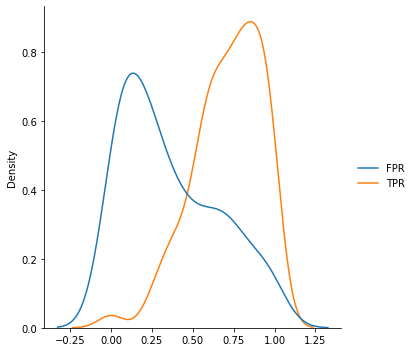

In [131]:
# fpr 과 tpr의 수치 시각화
# TPR 곡선과 FDR 곡선이 서로 겹칠수록 분류기의 성능은 떨어짐
sns.displot(roc.iloc[:, [0,1]], kind='kde')

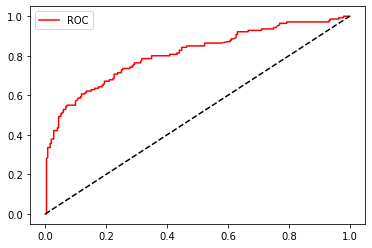

In [128]:
plt.plot(fprs, tprs, 'r', label='ROC',)
plt.plot([0,1], [0,1], 'k--')
plt.legend()

### AUC
* 
* 0.7 ~ 0.8 : normal
* 0.8 ~ 0.9 : good
* 0.9 ~ 1.0 : excellent

In [121]:
from sklearn.metrics import roc_auc_score

In [122]:
roc_auc_score(ytest, pred)

0.7416666666666667